# Preprocessing of Chest X-Ray Images for Pneumonia Detection

**Course / Deliverable:** Image Processing Project  
**Author:** Juan Pablo González Blandón - Santiago Castaño Loaiza  
**Date:** 23/09/2025

---

## Description

This notebook uses **200 chest X-ray images**, distributed as follows:

- 100 images of **healthy lungs (NORMAL)**  
- 100 images of **lungs with pneumonia (PNEUMONIA)**  

The images are organized in the following directories:

- data/samples/NORMAL
- /data/samples/PNEUMONIA/


---

## Objective

Apply a basic **image preprocessing and analysis workflow**, including:

- Normalization  
- Noise contamination 
- Filtering 
- Segmentation 
- Edge detection
- Histograms and histogram equalization  
- Calculation of the **PSNR (Peak Signal to Noise Ratio)** metric  

---

## Note

This notebook corresponds to the **first deliverable** of the course and is not intended to be exhaustive.  
In later stages, these images may be used for training and validating Machine Learning models for pneumonia detection.

# Libraries

In [4]:
import os
import random # For reproducibility in sampling
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from skimage.util import random_noise
from skimage.filters import rank # Median and Mean filters
from skimage.morphology import disk # Structuring element for rank filters
from skimage.util import img_as_ubyte
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.ndimage import uniform_filter
from skimage.filters import threshold_otsu 
from skimage.segmentation import watershed
from skimage.color import label2rgb # For visualizing segmentation
from skimage.feature import peak_local_max # For watershed
from skimage.measure import label # For connected components
from scipy import ndimage as ndi # For distance transform
from skimage import exposure # For histogram equalization and CLAHE
from skimage.filters import sobel
from skimage.feature import canny

# 1. Data Loading and Preview

In this section, we will:

- Load chest X-ray images from the directories `data/samples/NORMAL/` and `data/samples/PNEUMONIA/`.
- Display a few sample images from each class to visually confirm the dataset structure.

In [4]:
# Function to load image paths
def load_image_paths(directory, limit=None):
    """Return a list of image file paths from a directory."""
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if limit:
        return files[:limit]
    return files

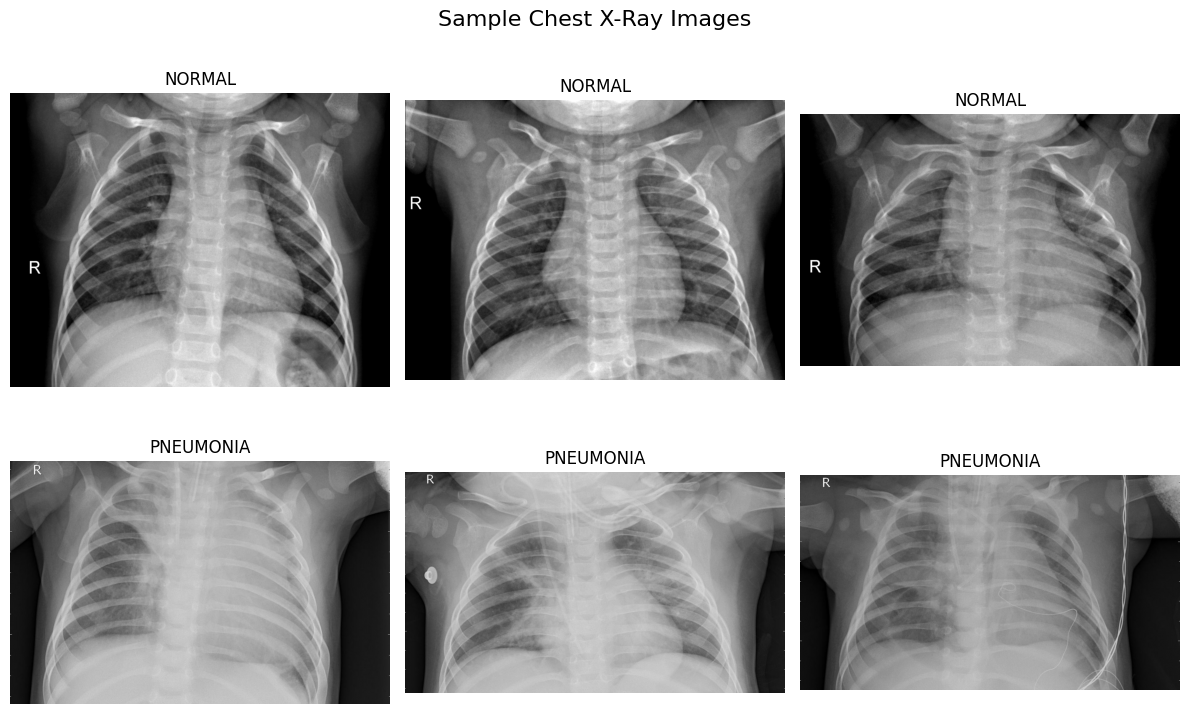

In [8]:
normal_dir = r"C:\Users\User\Documents\UdeA\Señales II\Proyecto Final\Pneumonia-Detection\data\samples\normal"
pneumonia_dir = r"C:\Users\User\Documents\UdeA\Señales II\Proyecto Final\Pneumonia-Detection\data\samples\pneumonia"

normal_samples = random.sample(load_image_paths(normal_dir), 3)
pneumonia_samples = random.sample(load_image_paths(pneumonia_dir), 3)

# Display images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, img_path in enumerate(normal_samples):
    img = Image.open(img_path).convert("L")
    axes[0, i].imshow(img, cmap="gray")
    axes[0, i].set_title("NORMAL")
    axes[0, i].axis("off")

for i, img_path in enumerate(pneumonia_samples):
    img = Image.open(img_path).convert("L")
    axes[1, i].imshow(img, cmap="gray")
    axes[1, i].set_title("PNEUMONIA")
    axes[1, i].axis("off")

plt.suptitle("Sample Chest X-Ray Images", fontsize=16)
plt.tight_layout()
plt.show()

# 2. Noise Simulation

In this step, we simulate two of the most common types of noise in medical imaging:

- **Gaussian noise**: random variations in pixel intensity following a normal distribution.  
- **Salt-and-Pepper noise**: random pixels are set to black or white, simulating impulse noise.

This will allow us to later test different filtering methods for noise removal.

In [11]:
def apply_noise(image, noise_type="gaussian", **kwargs):
    """
    Apply noise to an image (grayscale).
    
    Parameters
    ----------
    image : ndarray
        Input image in [0,255] uint8.
    noise_type : str
        Type of noise: 'gaussian', 's&p', 'poisson'.
    **kwargs : dict
        Extra parameters depending on noise type.
    
    Returns
    -------
    noisy_image : ndarray
        Noisy image scaled back to [0,255] uint8.
    """
    # Scale to [0,1] for skimage random_noise
    img_float = image.astype(np.float32) / 255.0
    noisy = random_noise(img_float, mode=noise_type, **kwargs)
    # Scale back to [0,255] for later normalize
    return (noisy * 255).astype(np.uint8)


def load_and_apply_noise(image_paths, noise_type="gaussian", **kwargs):
    """Load images, apply noise, return list of noisy images."""
    noisy_images = []
    for path in image_paths:
        img = Image.open(path).convert("L")  # grayscale
        img_np = np.array(img)
        noisy_img = apply_noise(img_np, noise_type=noise_type, **kwargs)
        noisy_images.append(noisy_img)
    return noisy_images

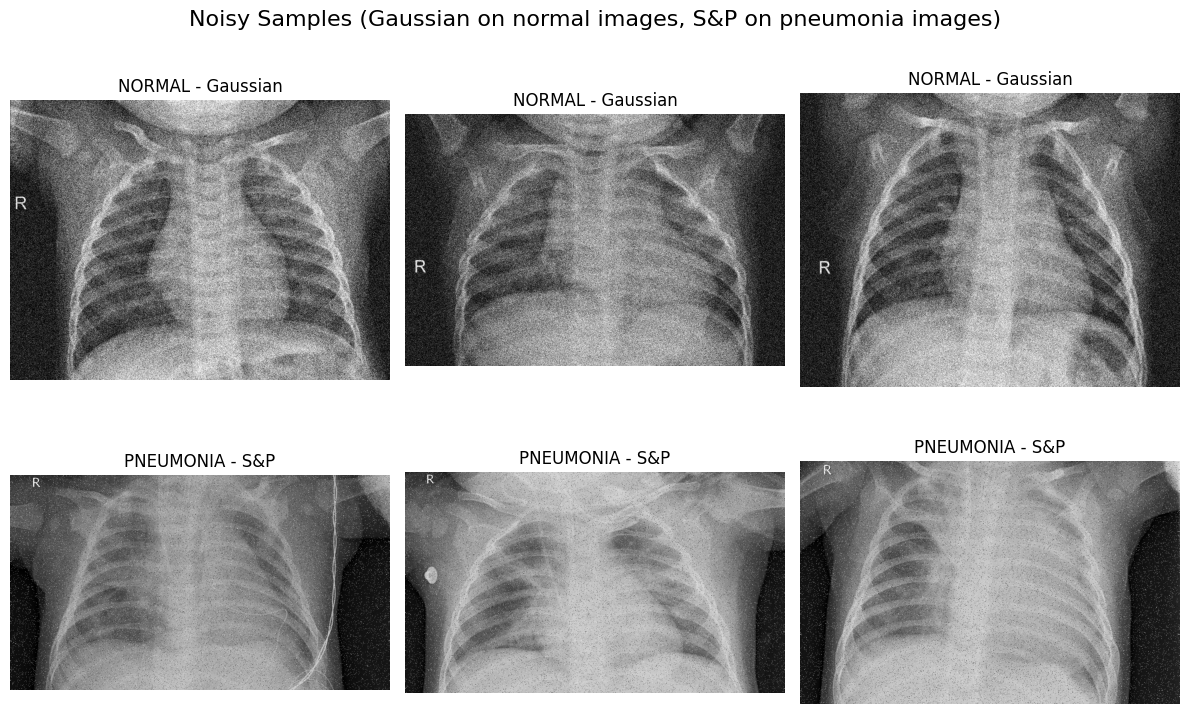

In [14]:
normal_noisy = load_and_apply_noise(normal_samples, noise_type="gaussian", var=0.1, mean=0)
pneumonia_noisy = load_and_apply_noise(pneumonia_samples, noise_type="s&p", amount=0.05, salt_vs_pepper=0.5)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# normal with Gaussian
for i, img in enumerate(random.sample(normal_noisy, 3)):
    axes[0, i].imshow(img, cmap="gray")
    axes[0, i].set_title("NORMAL - Gaussian")
    axes[0, i].axis("off")

# pneumonia with Salt & Pepper
for i, img in enumerate(random.sample(pneumonia_noisy, 3)):
    axes[1, i].imshow(img, cmap="gray")
    axes[1, i].set_title("PNEUMONIA - S&P")
    axes[1, i].axis("off")

plt.suptitle("Noisy Samples (Gaussian on normal images, S&P on pneumonia images)", fontsize=16)
plt.tight_layout()
plt.show()


# 3. Filtering

To reduce the noise added in the previous step, we apply two classical filters:

- **Mean filter (average smoothing):**  
  Works best against Gaussian noise by averaging neighboring pixel values, which reduces smooth variations.  

- **Median filter:**  
  Works best against Salt & Pepper noise by replacing each pixel with the median of its neighborhood, effectively removing isolated black/white pixels while preserving edges.

Later, we will compute the **PSNR** to quantify how well the noise was reduced.

In [16]:
def apply_filter(image, filter_type="mean", **kwargs):
    """
    Apply a filter to a noisy grayscale image.
    
    Parameters
    ----------
    image : ndarray
        Input noisy image (uint8).
    filter_type : str
        "mean" or "median".
    **kwargs : dict
        Extra parameters (kernel size).
    
    Returns
    -------
    filtered : ndarray
        Filtered image.
    """
    if filter_type == "mean":
        size = kwargs.get("size", 3)
        filtered = uniform_filter(image, size=size)
    elif filter_type == "median":
        size = kwargs.get("size", 3)
        filtered = rank.median(img_as_ubyte(image), disk(size))
    else:
        raise ValueError("Filter type must be 'mean' or 'median'")
    return filtered


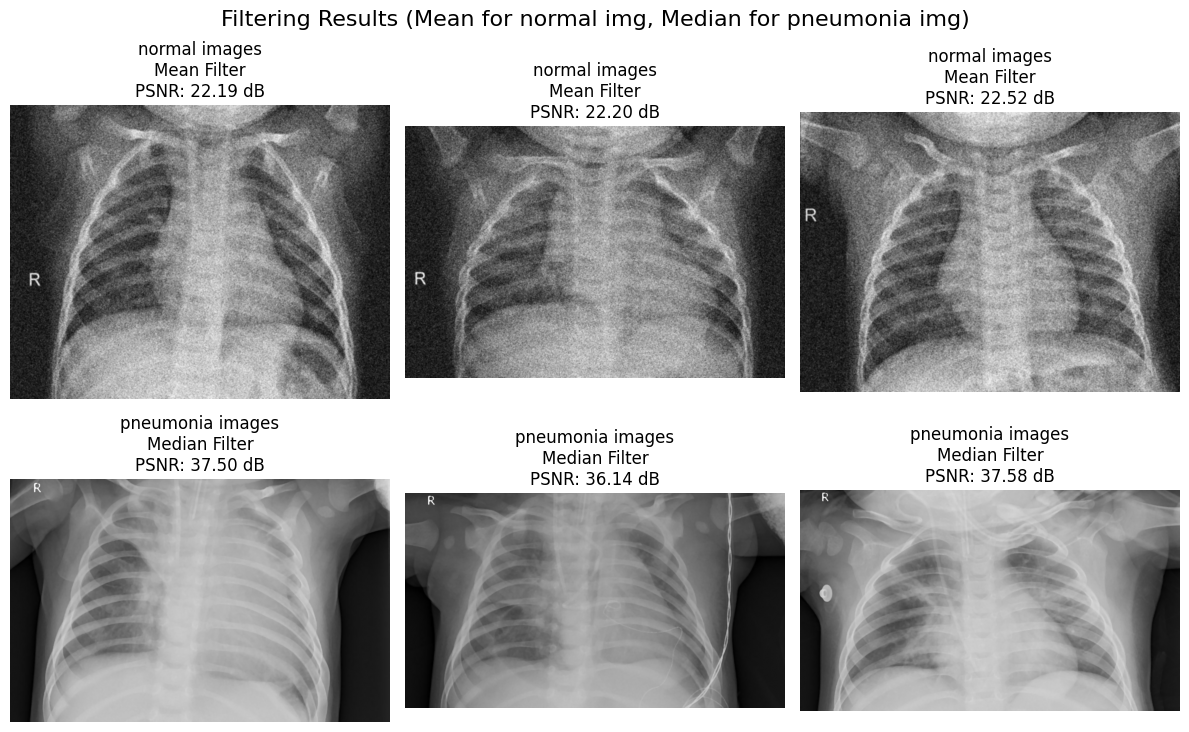

In [21]:
normal_filtered = [apply_filter(img, filter_type="mean", size=5) for img in normal_noisy]
pneumonia_filtered = [apply_filter(img, filter_type="median", size=3) for img in pneumonia_noisy]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# NORMAL (Gaussian noise - Mean filter)
for i, idx in enumerate(random.sample(range(len(normal_noisy)), 3)):
    axes[0, i].imshow(normal_filtered[idx], cmap="gray")
    psnr_val = psnr(np.array(Image.open(normal_samples[idx]).convert("L")), normal_filtered[idx])
    axes[0, i].set_title(f"normal images\nMean Filter\nPSNR: {psnr_val:.2f} dB")
    axes[0, i].axis("off")

# PNEUMONIA (Salt & Pepper noise - Median filter)
for i, idx in enumerate(random.sample(range(len(pneumonia_noisy)), 3)):
    axes[1, i].imshow(pneumonia_filtered[idx], cmap="gray")
    psnr_val = psnr(np.array(Image.open(pneumonia_samples[idx]).convert("L")), pneumonia_filtered[idx])
    axes[1, i].set_title(f"pneumonia images\nMedian Filter\nPSNR: {psnr_val:.2f} dB")
    axes[1, i].axis("off")

plt.suptitle("Filtering Results (Mean for normal img, Median for pneumonia img)", fontsize=16)
plt.tight_layout()
plt.show()

# 4. Segmentation

We apply different segmentation techniques depending on the class:

- **NORMAL images (100 samples)** → segmented using **Otsu's thresholding**.  
  Otsu automatically selects a global threshold value by minimizing intra-class variance.  

- **PNEUMONIA images (100 samples)** → segmented using the **Watershed algorithm**.  
  Watershed treats the image as a topographic surface and "floods" it to separate distinct regions, which is particularly useful in more complex structures.

This design allows us to compare how different segmentation strategies behave on different classes.


In [33]:
def apply_segmentation(image, method="otsu"):
    """
    Apply segmentation to a grayscale image.
    
    Parameters
    ----------
    image : ndarray
        Input grayscale image (uint8).
    method : str
        "otsu" or "watershed".
    
    Returns
    -------
    segmented : ndarray
        Binary or labeled segmentation mask.
    """
    if method == "otsu":
        # Global Otsu threshold
        thresh = threshold_otsu(image)
        segmented = image < thresh
    
    elif method == "watershed":
        # Compute the distance transform
        distance = ndi.distance_transform_edt(image)
        
        # Find local maxima as markers
        coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndi.label(mask)
        
        # Apply watershed
        segmented = watershed(-distance, markers, mask=image)
    
    else:
        raise ValueError("Method must be 'otsu' or 'watershed'")
    
    return segmented

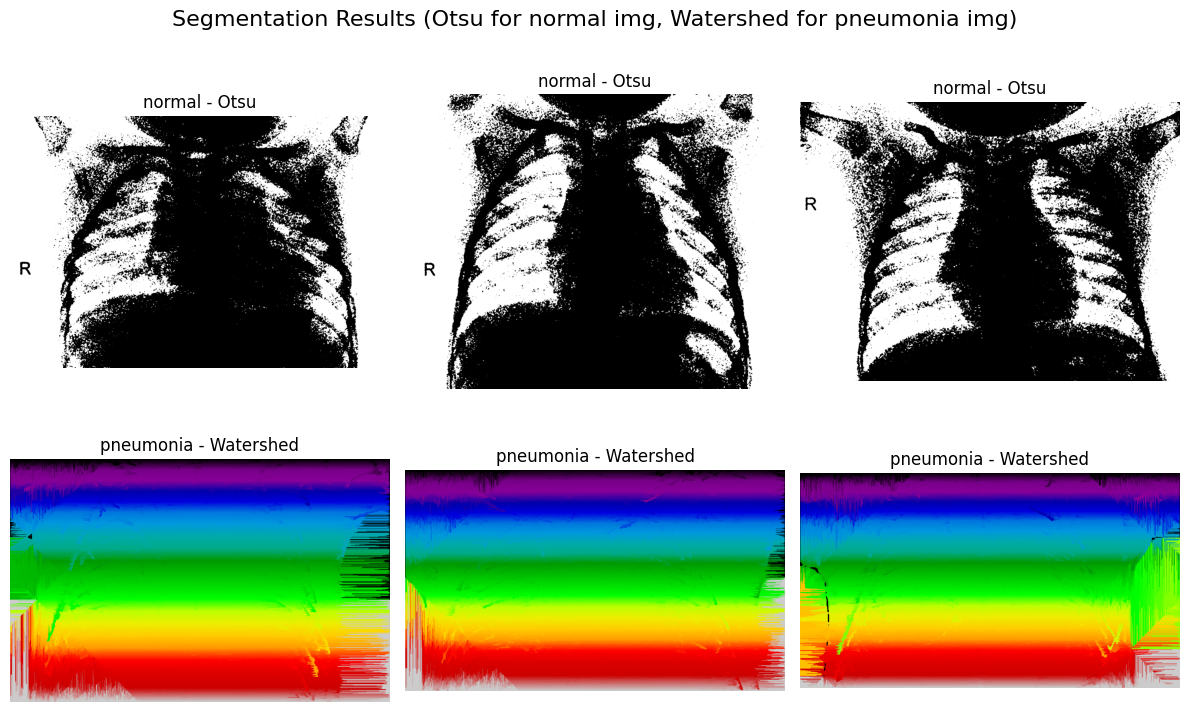

In [35]:
normal_segmented = [apply_segmentation(img, method="otsu") for img in normal_filtered]
pneumonia_segmented = [apply_segmentation(img, method="watershed") for img in pneumonia_filtered]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# normal (Otsu)
for i, idx in enumerate(random.sample(range(len(normal_filtered)), 3)):
    axes[0, i].imshow(normal_segmented[idx], cmap="gray")
    axes[0, i].set_title("normal - Otsu")
    axes[0, i].axis("off")

# pneumonia (Watershed)
for i, idx in enumerate(random.sample(range(len(pneumonia_filtered)), 3)):
    axes[1, i].imshow(pneumonia_segmented[idx], cmap="nipy_spectral")
    axes[1, i].set_title("pneumonia - Watershed")
    axes[1, i].axis("off")

plt.suptitle("Segmentation Results (Otsu for normal img, Watershed for pneumonia img)", fontsize=16)
plt.tight_layout()
plt.show()

## Conclusion

Watershed is **not suitable** for this dataset without prior region-of-interest (ROI) extraction, for example using a deep learning segmentation model (e.g., U-Net trained for lung field extraction).  

For this reason, we will focus on **histograms, contrast enhancement, and edge detection**, which provide more useful insights for chest X-rays.

# Extra Section: Watershed with ROI (Region of Interest)

To demonstrate the importance of having a proper binary mask, we apply Watershed segmentation only within a **Region of Interest (ROI)**:

- For demonstration, the ROI is obtained using a simple **Otsu threshold** to generate a binary mask.  
- Watershed is then applied **only inside this mask**.  

This greatly reduces over-segmentation and produces more meaningful regions compared to running Watershed on the entire image.

In [47]:
def watershed_with_roi(image, min_distance=15):
    """
    Apply Watershed segmentation inside an ROI obtained by Otsu threshold.
    """
    # 1. ROI mask using Otsu
    thresh = threshold_otsu(image)
    roi_mask = image > thresh
    
    # 2. Distance transform inside ROI
    distance = ndi.distance_transform_edt(roi_mask)
    
    # 3. Local maxima as markers
    coords = peak_local_max(distance, min_distance=min_distance, labels=roi_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    
    # 4. Watershed segmentation limited by ROI
    labels_ws = watershed(-distance, markers, mask=roi_mask)
    
    return labels_ws, roi_mask

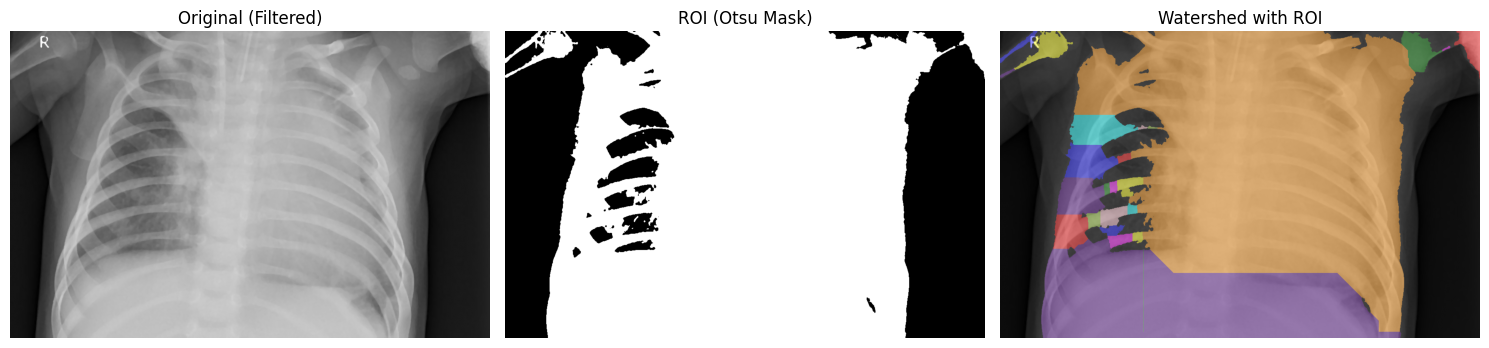

In [48]:
example_img = pneumonia_filtered[0]
labels_ws, roi_mask = watershed_with_roi(example_img)

# Overlay
overlay = label2rgb(labels_ws, image=example_img, bg_label=0, alpha=0.4)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(example_img, cmap="gray")
axes[0].set_title("Original (Filtered)")
axes[0].axis("off")

axes[1].imshow(roi_mask, cmap="gray")
axes[1].set_title("ROI (Otsu Mask)")
axes[1].axis("off")

axes[2].imshow(overlay)
axes[2].set_title("Watershed with ROI")
axes[2].axis("off")

plt.tight_layout()
plt.show()

## Conclusion of this extra section

By applying Watershed inside a Region of Interest (ROI), the segmentation results were significantly improved, showing the importance of a proper binary mask before using region-based methods.

# 5. Histogram Analysis and Contrast Enhancement

X-ray images often suffer from **low global contrast**, making subtle structures harder to distinguish.  
To analyze this, we compare the **histograms of intensity values** for both normal and pneumonia samples.


In [54]:
def plot_image_histograms(image, title="Sample", clip_limit=0.03):
    """
    Show original, histogram equalized, and CLAHE images
    with their corresponding histograms.
    
    Parameters
    ----------
    image : ndarray
        Grayscale image normalized to [0,1].
    title : str
        Title for the sample (e.g., NORMAL 1).
    clip_limit : float
        CLAHE contrast limit (default=0.03).
    """
    
    # Global Histogram Equalization
    img_eq = exposure.equalize_hist(image)
    
    # Adaptive Histogram Equalization (CLAHE)
    img_clahe = exposure.equalize_adapthist(image, clip_limit=clip_limit)
    
    # Plot
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    
    # ---- Original ----
    axes[0,0].imshow(image, cmap="gray")
    axes[0,0].set_title(f"{title} - Original")
    axes[0,0].axis("off")
    axes[0,1].hist(image.ravel(), bins=256, range=(0,1), histtype="step", color="black")
    axes[0,1].set_title("Histogram (Original)")
    
    # ---- Equalized ----
    axes[1,0].imshow(img_eq, cmap="gray")
    axes[1,0].set_title("Histogram Equalization")
    axes[1,0].axis("off")
    axes[1,1].hist(img_eq.ravel(), bins=256, range=(0,1), histtype="step", color="black")
    axes[1,1].set_title("Histogram (Equalized)")
    
    # ---- CLAHE ----
    axes[2,0].imshow(img_clahe, cmap="gray")
    axes[2,0].set_title("CLAHE")
    axes[2,0].axis("off")
    axes[2,1].hist(img_clahe.ravel(), bins=256, range=(0,1), histtype="step", color="black")
    axes[2,1].set_title("Histogram (CLAHE)")
    
    plt.tight_layout()
    plt.show()
    
    return img_eq, img_clahe


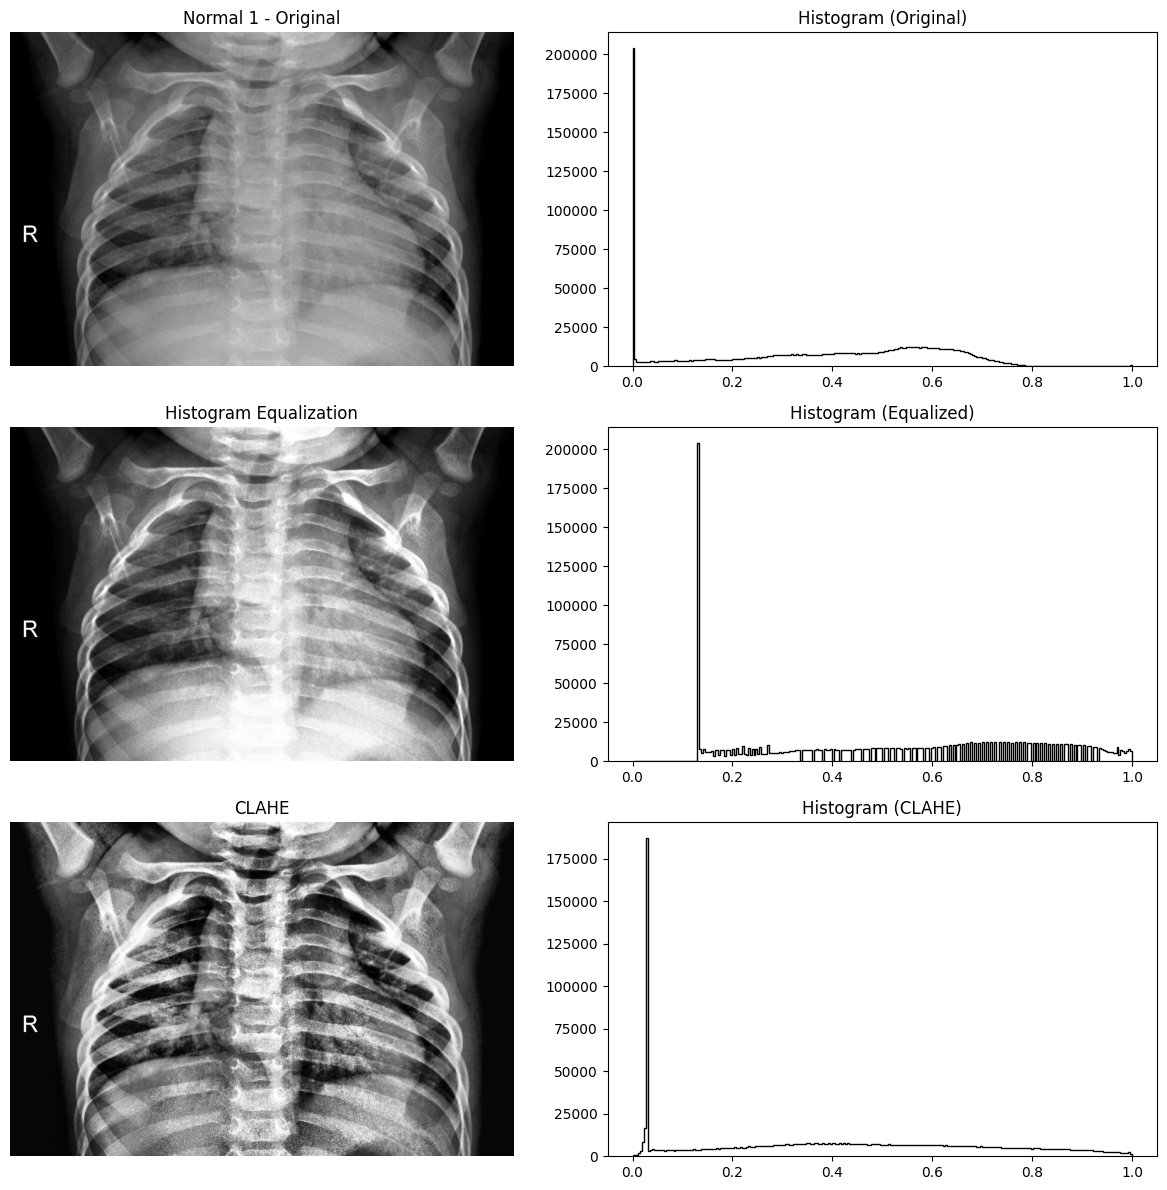

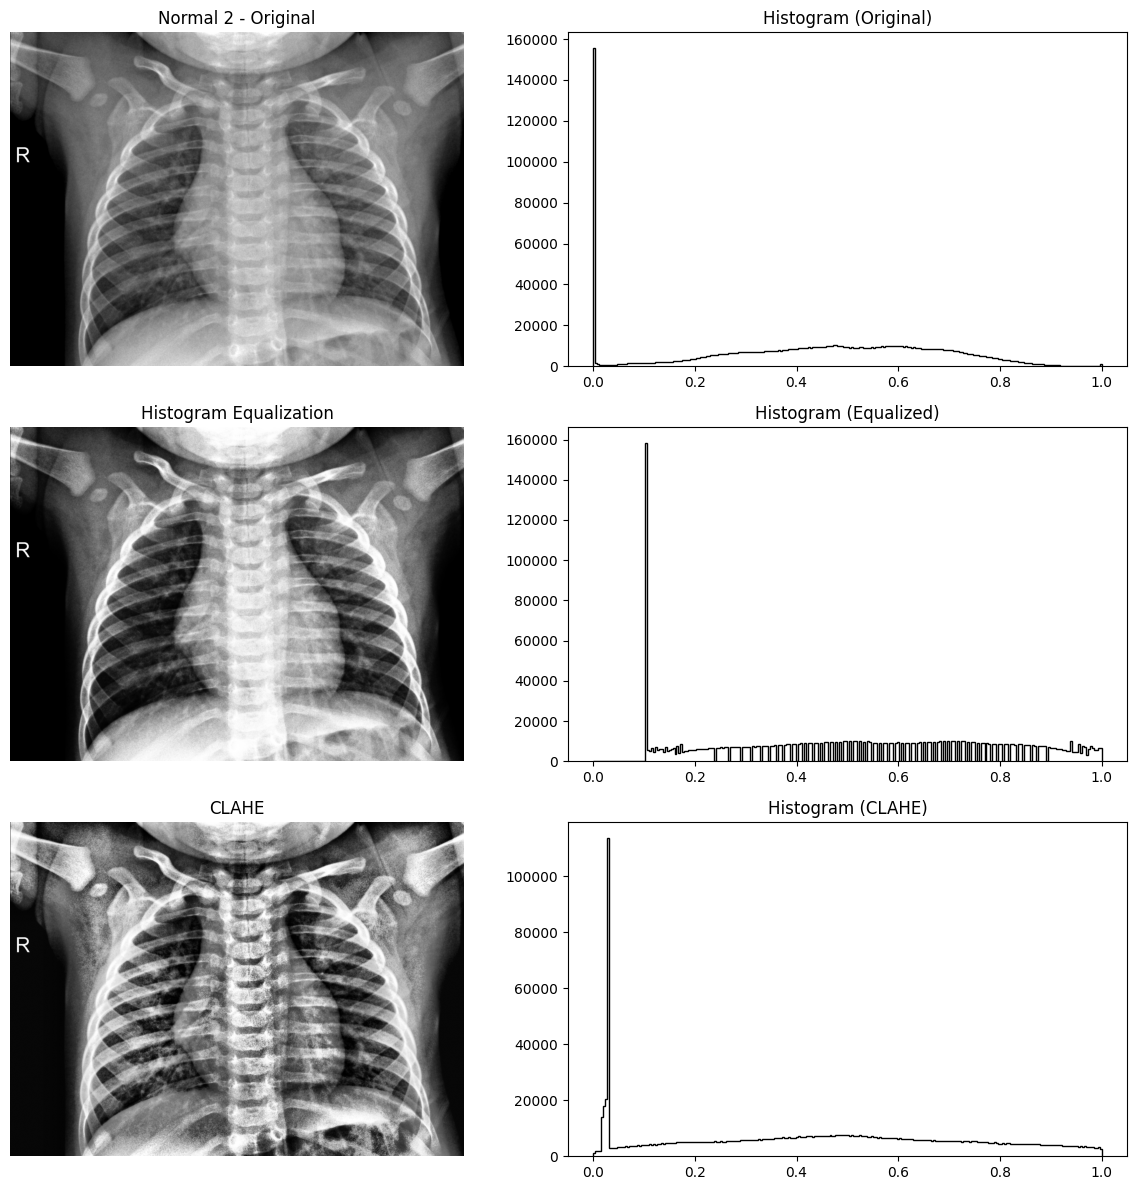

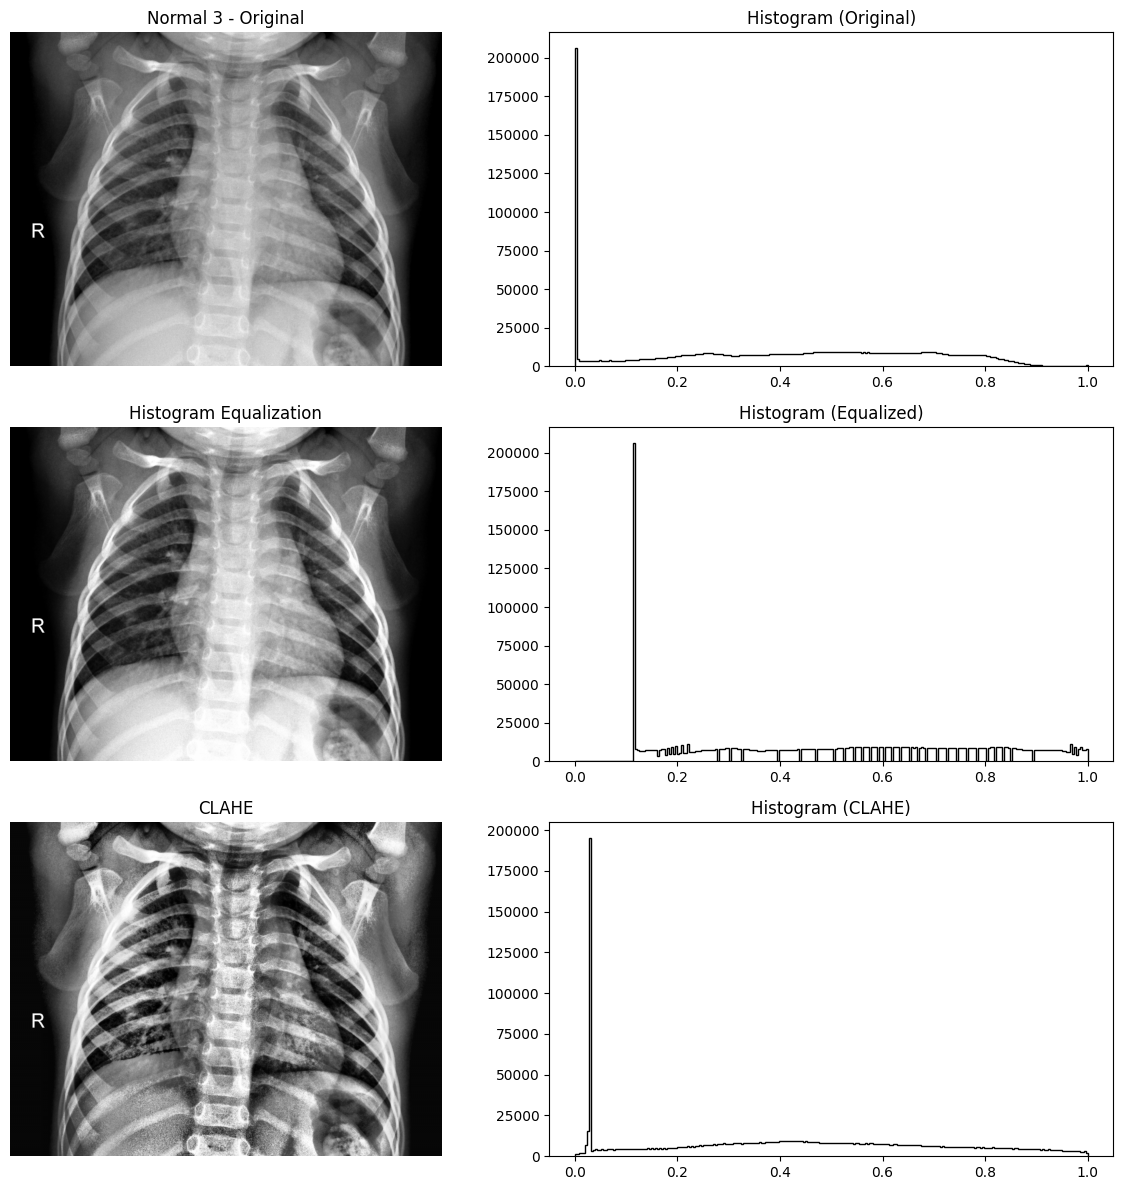

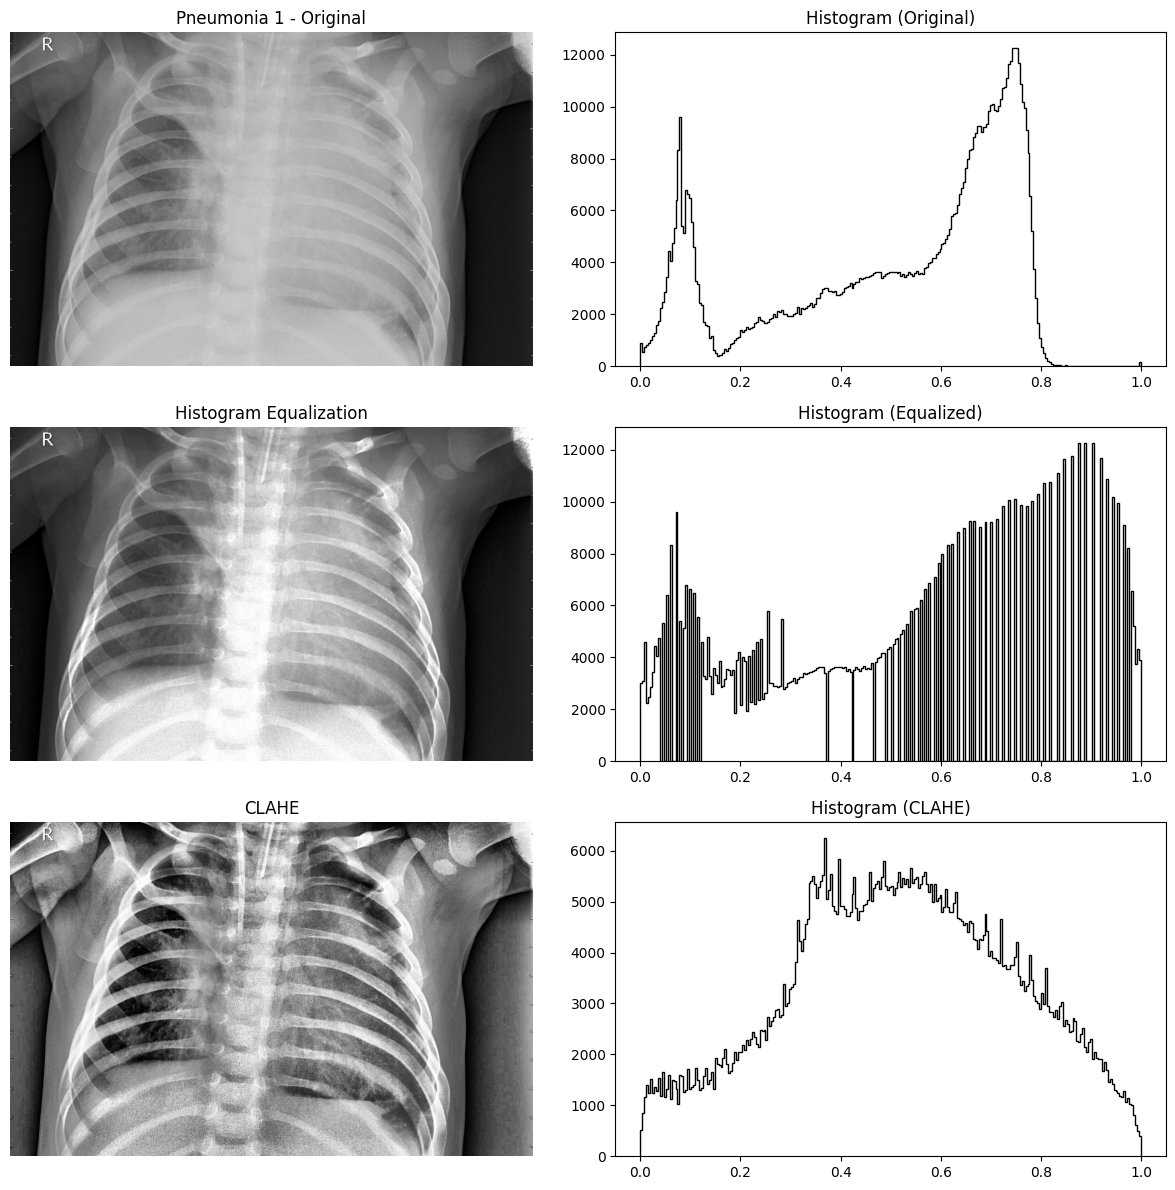

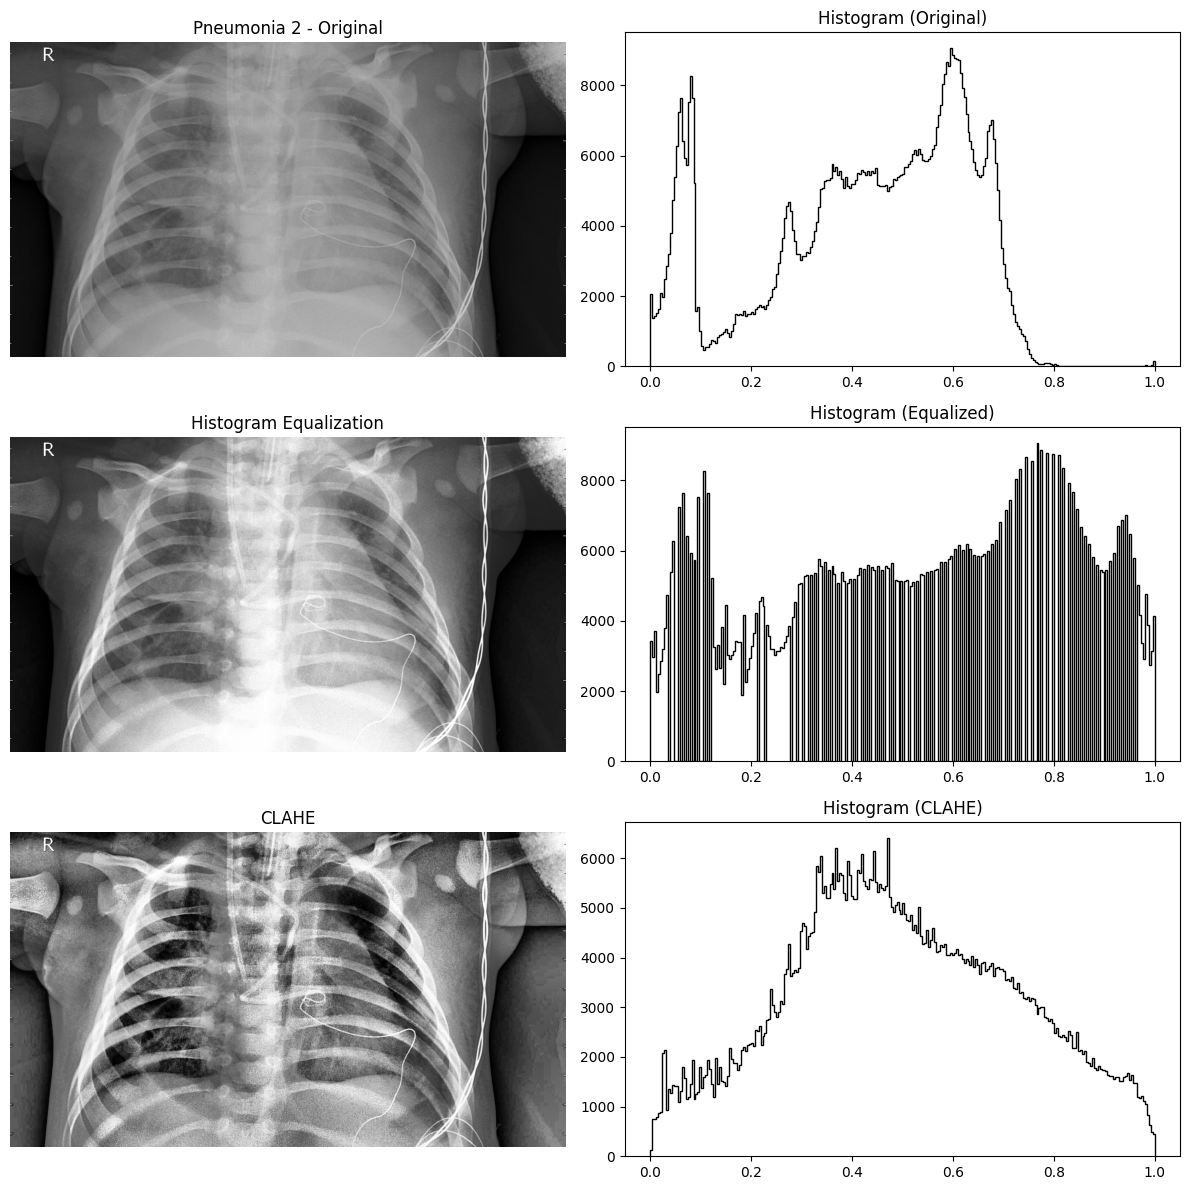

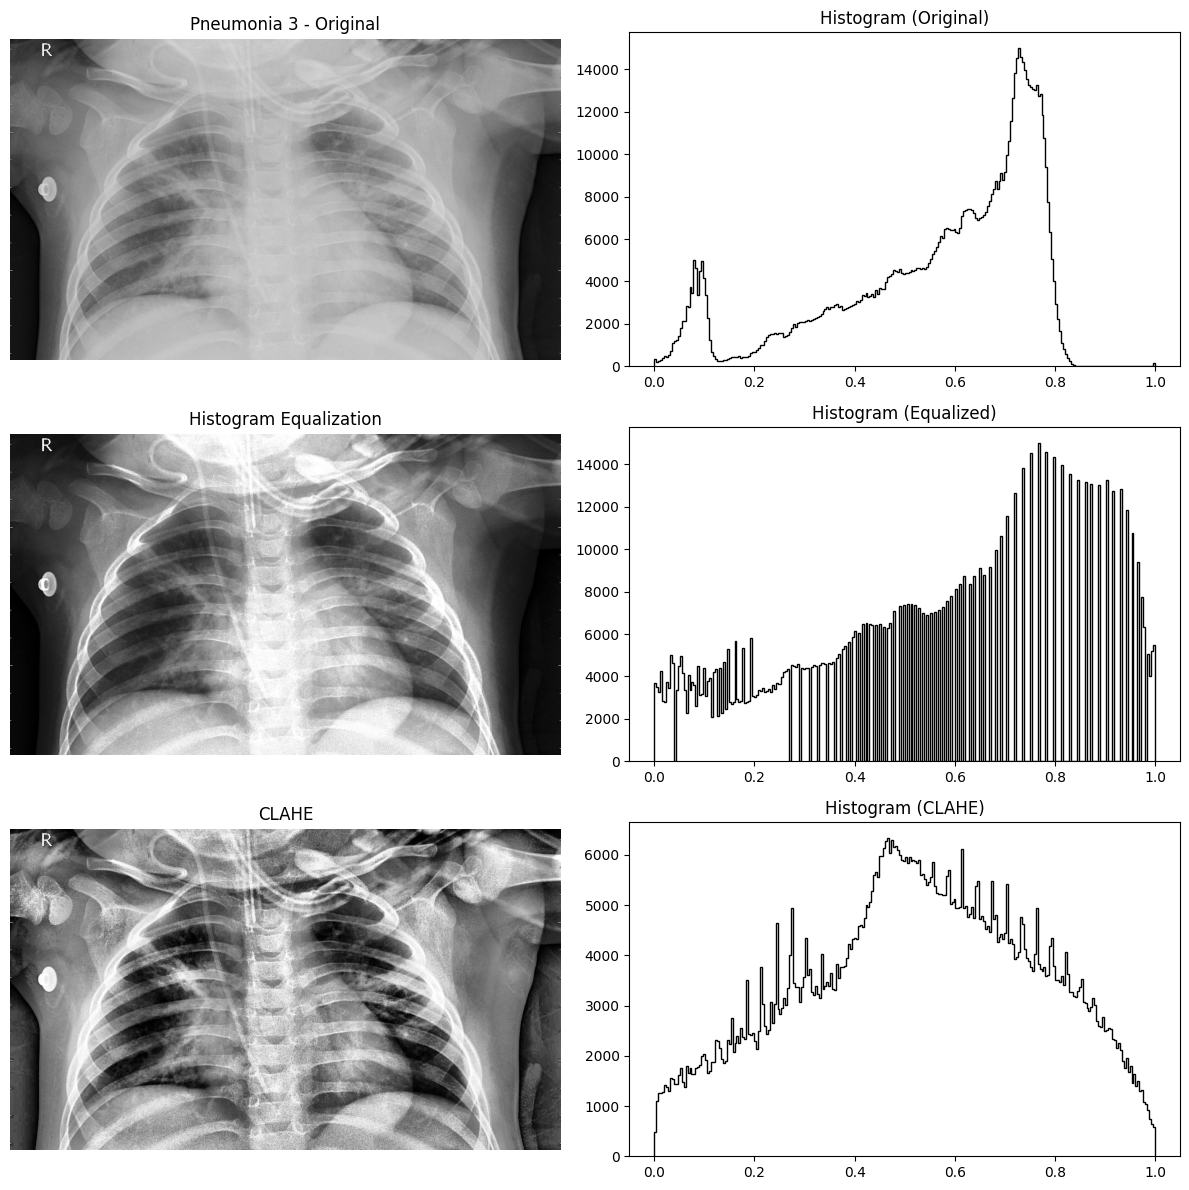

In [62]:
random_normals = random.sample(normal_samples, 3)
random_pneumonias = random.sample(pneumonia_samples, 3)

normal_clahe_list = []
pneu_clahe_list = []

# normals
for i, path in enumerate(random_normals):
    img = np.array(Image.open(path).convert("L")) / 255.0
    _, img_clahe = plot_image_histograms(img, title=f"Normal {i+1}")
    normal_clahe_list.append(img_clahe)

# pneumonias
for i, path in enumerate(random_pneumonias):
    img = np.array(Image.open(path).convert("L")) / 255.0
    _, img_clahe = plot_image_histograms(img, title=f"Pneumonia {i+1}")
    pneu_clahe_list.append(img_clahe)


## Conclusion on CLAHE

Applying CLAHE (Contrast Limited Adaptive Histogram Equalization) enhanced the visibility of mid-gray regions in chest X-rays.  
- In **normal** cases, the effect is minor since lungs are mostly dark.  
- In **pneumonia** cases, CLAHE highlights cloudy opacities, making them more distinguishable.  

This makes CLAHE a useful preprocessing step for **edge detection** and **feature extraction**, though it should be applied carefully in medical imaging.


# 6. Edge Detection

We apply different edge detection techniques based on image characteristics:

NORMAL images → Processed with Sobel operator

Better for gradual transitions in healthy lung X-rays
Enhanced with gamma correction (img**0.5) for better contrast
Shows continuous edge gradients
PNEUMONIA images → Processed with Canny detector

Parameters tuned for medical imaging:
sigma=2: Reduces noise sensitivity
low_threshold=0.1
high_threshold=0.3
Better at detecting sharp transitions in affected areas
Produces binary edges with hysteresis thresholding
These methods complement the CLAHE preprocessing, helping to:

Highlight anatomical structures
Detect potential areas of inflammation
Preserve important diagnostic features

In [60]:
def plot_edges(original, edges, method="Sobel", title="Sample"):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original, cmap="gray")
    axes[0].set_title(f"{title} - CLAHE")
    axes[0].axis("off")
    
    axes[1].imshow(edges, cmap="gray")
    axes[1].set_title(f"{title} - {method} Edges")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

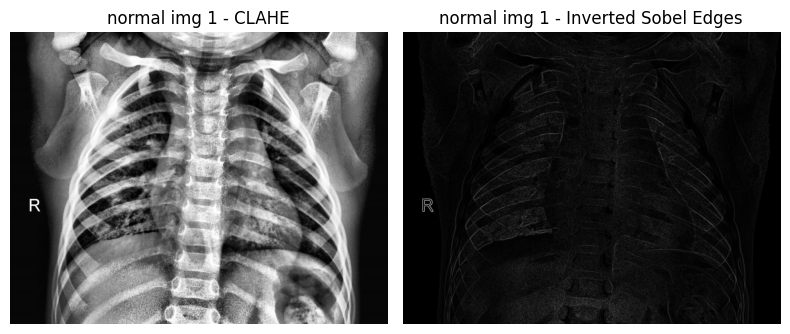

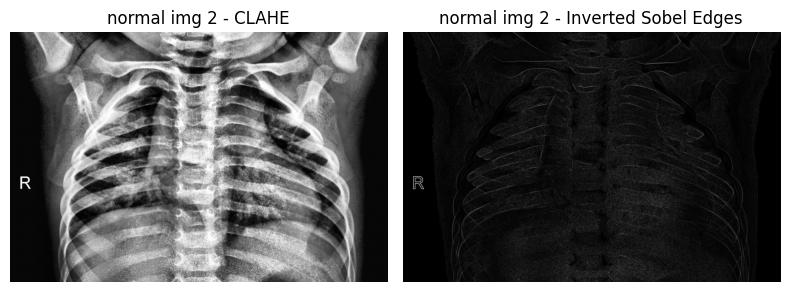

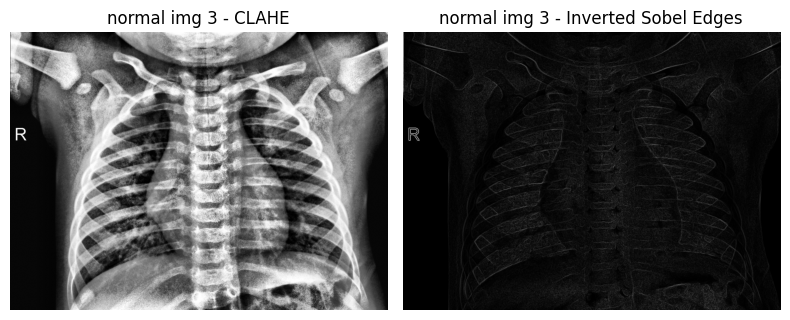

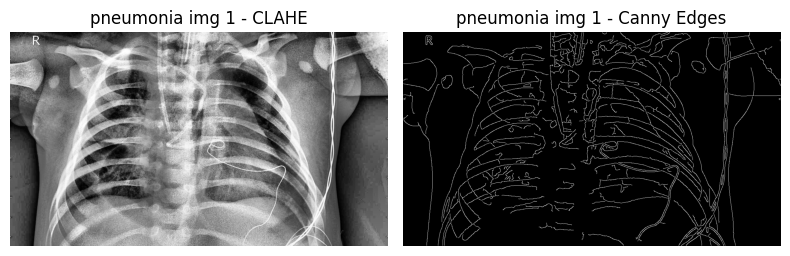

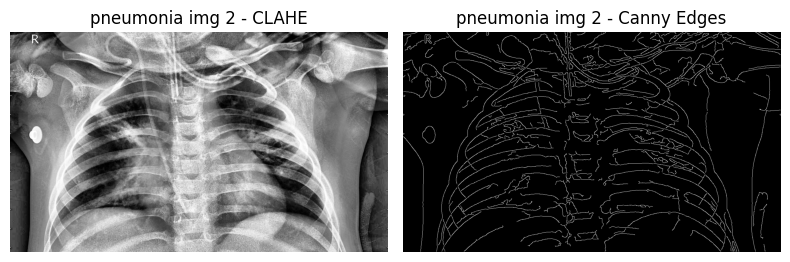

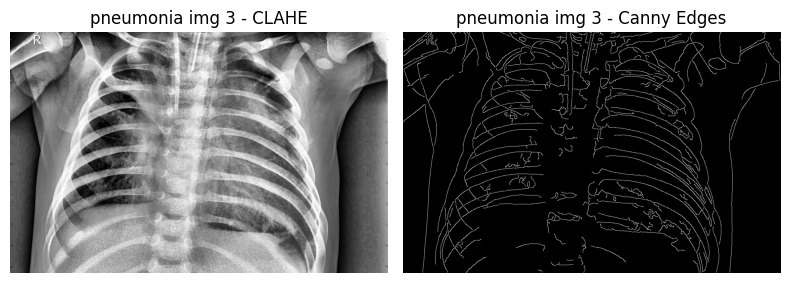

In [74]:
normal_edges_sobel = [sobel(img**0.5) for img in normal_clahe_list]
pneumonia_edges_canny = [canny(img, sigma=2, low_threshold=0.1, high_threshold=0.3) for img in pneu_clahe_list]

random_pneumonias = random.sample(list(zip(pneu_clahe_list, pneumonia_edges_canny)), 3)
random_normals = random.sample(list(zip(normal_clahe_list, normal_edges_sobel)), 3)

for i, (clahe_img, sobel_img) in enumerate(random_normals):
    plot_edges(clahe_img, sobel_img, method="Inverted Sobel", title=f"normal img {i+1}")
    
for i, (clahe_img, canny_img) in enumerate(random_pneumonias):
    plot_edges(clahe_img, canny_img, method="Canny", title=f"pneumonia img {i+1}")

# 7. Image Normalization for Machine Learning

Before feeding our preprocessed images into a machine learning model, we should apply appropriate normalization techniques. For chest X-ray classification, we recommend:

**Min-Max Scaling to [0,1] range**

- Preserves relative intensity differences
- Standardizes input range across all images
- Important for CNN architectures

For our specific pneumonia detection case, Min-Max scaling would be more appropriate because:

- We've already enhanced contrast with CLAHE
- Relative intensity differences are crucial for identifying opacities
- CNNs typically work better with bounded [0,1] inputs
- Medical imaging protocols often maintain consistent exposure settings

In [76]:
def apply_minmax_scaling(images):
    """
    Apply Min-Max scaling to a list of images.
    
    Parameters
    ----------
    images : list
        List of images to normalize
        
    Returns
    -------
    normalized : list
        List of normalized images in range [0,1]
    """
    normalized = []
    for img in images:
        # Ensure float type
        img = img.astype(float)
        # Apply Min-Max formula: (x - min) / (max - min)
        norm_img = (img - img.min()) / (img.max() - img.min())
        normalized.append(norm_img)
    return normalized

In [78]:
# Apply normalization to CLAHE images
normal_normalized = apply_minmax_scaling(normal_clahe_list)
pneumonia_normalized = apply_minmax_scaling(pneu_clahe_list)

# Verify Ranges
print("Normal images range:", 
      f"min={min([img.min() for img in normal_normalized]):.3f}",
      f"max={max([img.max() for img in normal_normalized]):.3f}")
print("Pneumonia images range:", 
      f"min={min([img.min() for img in pneumonia_normalized]):.3f}",
      f"max={max([img.max() for img in pneumonia_normalized]):.3f}")

Normal images range: min=0.000 max=1.000
Pneumonia images range: min=0.000 max=1.000


# Apply Clahe and redim All Images


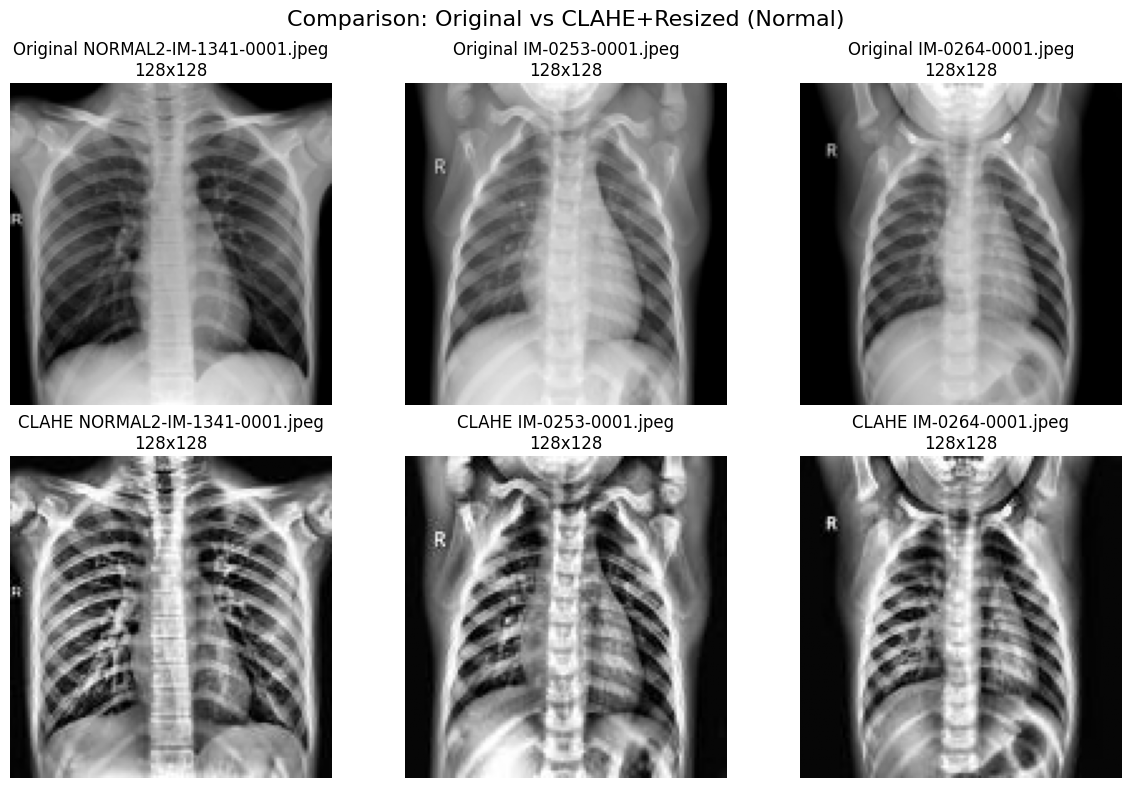

In [6]:
def load_image_paths(directory):
    """
    Return a list of image file paths from a directory.
    """
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

def apply_clahe_and_resize(image_paths, output_dir, size=(128, 128), clip_limit=0.03):
    """
    Apply CLAHE and resize to all images, then save them in output_dir.
    Overwrites files if they already exist.
    
    Args:
        image_paths (list): List of input image paths.
        output_dir (str): Directory to save processed images.
        size (tuple): Target size (width, height).
        clip_limit (float): CLAHE clip limit.
    
    Returns:
        list: List of output image paths.
    """
    os.makedirs(output_dir, exist_ok=True)
    output_paths = []
    for path in image_paths:
        # Load, convert to grayscale, resize, and normalize
        img = Image.open(path).convert("L").resize(size)
        img_np = np.array(img) / 255.0
        # Apply CLAHE
        img_clahe = exposure.equalize_adapthist(img_np, clip_limit=clip_limit)
        # Convert back to uint8 for saving
        img_clahe_uint8 = (img_clahe * 255).astype(np.uint8)
        # Output filename (overwrite if exists)
        fname = os.path.basename(path)
        out_path = os.path.join(output_dir, fname)
        Image.fromarray(img_clahe_uint8).save(out_path)
        output_paths.append(out_path)
    return output_paths

# Input and output directories
normal_dir = r"C:\Users\User\Documents\UdeA\Señales II\Proyecto Final\Pneumonia-Detection\data\samples\normal"
pneumonia_dir = r"C:\Users\User\Documents\UdeA\Señales II\Proyecto Final\Pneumonia-Detection\data\samples\pneumonia"
normal_out = r"C:\Users\User\Documents\UdeA\Señales II\Proyecto Final\Pneumonia-Detection\data\processed\normal"
pneumonia_out = r"C:\Users\User\Documents\UdeA\Señales II\Proyecto Final\Pneumonia-Detection\data\processed\pneumonia"

# Load original image paths
normal_paths = load_image_paths(normal_dir)
pneumonia_paths = load_image_paths(pneumonia_dir)

# Apply CLAHE and resize, overwrite processed images
normal_clahe_paths = apply_clahe_and_resize(normal_paths, normal_out, size=(128, 128))
pneumonia_clahe_paths = apply_clahe_and_resize(pneumonia_paths, pneumonia_out, size=(128, 128))

# Visualize 3 random original and processed images (example with normal)
idx = np.random.choice(len(normal_paths), 3, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ix in enumerate(idx):
    # Original image (resized for fair comparison)
    img_orig = np.array(Image.open(normal_paths[ix]).convert("L").resize((128, 128)))
    axes[0, i].imshow(img_orig, cmap="gray")
    axes[0, i].set_title(f"Original {os.path.basename(normal_paths[ix])}\n{img_orig.shape[1]}x{img_orig.shape[0]}")
    axes[0, i].axis("off")
    # CLAHE image
    img_clahe = np.array(Image.open(normal_clahe_paths[ix]).convert("L"))
    axes[1, i].imshow(img_clahe, cmap="gray")
    axes[1, i].set_title(f"CLAHE {os.path.basename(normal_clahe_paths[ix])}\n{img_clahe.shape[1]}x{img_clahe.shape[0]}")
    axes[1, i].axis("off")

plt.suptitle("Comparison: Original vs CLAHE+Resized (Normal)", fontsize=16)
plt.tight_layout()
plt.show()